# NBA Shot Success Deep Learning Model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from skopt.space import Real, Categorical, Integer
from skopt import BayesSearchCV
import re
from datetime import time

sns.set(style='white')

## Data Loading

In [3]:
nba_df = pd.read_csv('shot_logs.csv')
nba_df.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,...,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,1:09,10.8,2,...,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,0:14,3.4,0,...,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,0:00,NaN,3,...,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47,10.3,2,...,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34,10.9,2,...,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


The dataset looks fairly clean from this perspective. Free throws are not included, overtimes are, the final margin is measured in reference to the team. If the team loses then the final_margin is negative. It would be useful to seperate out the matchup column into a mathup date and matchup team column.

In [3]:
nba_df.columns

Index(['GAME_ID', 'MATCHUP', 'LOCATION', 'W', 'FINAL_MARGIN', 'SHOT_NUMBER',
       'PERIOD', 'GAME_CLOCK', 'SHOT_CLOCK', 'DRIBBLES', 'TOUCH_TIME',
       'SHOT_DIST', 'PTS_TYPE', 'SHOT_RESULT', 'CLOSEST_DEFENDER',
       'CLOSEST_DEFENDER_PLAYER_ID', 'CLOSE_DEF_DIST', 'FGM', 'PTS',
       'player_name', 'player_id'],
      dtype='object')

In [4]:
nba_df.describe()

,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id
count,1.280690e+05,128069.000000,128069.000000,128069.000000,122502.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000,128069.000000
mean,2.140045e+07,0.208723,6.506899,2.469427,12.453344,2.023355,2.765901,13.571504,2.264670,159038.487284,4.123015,0.452139,0.997314,157238.251247
std,2.578773e+02,13.233267,4.713260,1.139919,5.763265,3.477760,3.043682,8.888964,0.441159,78791.172947,2.756446,0.497706,1.130978,79362.389336
min,2.140000e+07,-53.000000,1.000000,1.000000,0.000000,0.000000,-163.600000,0.000000,2.000000,708.000000,0.000000,0.000000,0.000000,708.000000
25%,2.140023e+07,-8.000000,3.000000,1.000000,8.200000,0.000000,0.900000,4.700000,2.000000,101249.000000,2.300000,0.000000,0.000000,101162.000000
50%,2.140045e+07,1.000000,5.000000,2.000000,12.300000,1.000000,1.600000,13.700000,2.000000,201949.000000,3.700000,0.000000,0.000000,201939.000000
75%,2.140067e+07,9.000000,9.000000,3.000000,16.675000,2.000000,3.700000,22.500000,3.000000,203079.000000,5.300000,1.000000,2.000000,202704.000000
max,2.140091e+07,53.000000,38.000000,7.000000,24.000000,32.000000,24.900000,47.200000,3.000000,530027.000000,53.200000,1.000000,3.000000,204060.000000


## Data Cleaning

### Duplicates & Column Names

In [5]:
#checking for duplicated rows
duplicates = nba_df.duplicated()
n = 0
for i in duplicates:
    if i is True:
        n += 1
print('Number of duplicate rows in the dataset:', n)

Number of duplicate rows in the dataset: 0


In [6]:
#where are the nulls located so that they can be handled
nba_df.isnull().any()

GAME_ID                       False
MATCHUP                       False
LOCATION                      False
W                             False
FINAL_MARGIN                  False
SHOT_NUMBER                   False
PERIOD                        False
GAME_CLOCK                    False
SHOT_CLOCK                     True
DRIBBLES                      False
TOUCH_TIME                    False
SHOT_DIST                     False
PTS_TYPE                      False
SHOT_RESULT                   False
CLOSEST_DEFENDER              False
CLOSEST_DEFENDER_PLAYER_ID    False
CLOSE_DEF_DIST                False
FGM                           False
PTS                           False
player_name                   False
player_id                     False
dtype: bool

In [4]:
nba_df.columns = map(str.lower, nba_df.columns)
nba_df['closest_defender'] = nba_df['closest_defender'].str.lower()
print(nba_df.columns)
print(nba_df.dtypes)

Index(['game_id', 'matchup', 'location', 'w', 'final_margin', 'shot_number',
       'period', 'game_clock', 'shot_clock', 'dribbles', 'touch_time',
       'shot_dist', 'pts_type', 'shot_result', 'closest_defender',
       'closest_defender_player_id', 'close_def_dist', 'fgm', 'pts',
       'player_name', 'player_id'],
      dtype='object')
game_id                         int64
matchup                        object
location                       object
w                              object
final_margin                    int64
shot_number                     int64
period                          int64
game_clock                     object
shot_clock                    float64
dribbles                        int64
touch_time                    float64
shot_dist                     float64
pts_type                        int64
shot_result                    object
closest_defender               object
closest_defender_player_id      int64
close_def_dist                float64
fgm         

### Matchup Column Teams and Dates

In [5]:
#splitting out the matchup column into the teams and the date
matchup = nba_df['matchup'].str.split('-')
n=0
teams = []
match_date = []
for i in matchup:
    hold = re.sub(r'[\s+]', '', matchup[n][1])
    teams.append(hold)
    match_date.append(matchup[n][0])
    n+=1
nba_df['teams'] = teams
nba_df['match_date'] = match_date

In [6]:
nba_df['match_date'] = pd.to_datetime(nba_df['match_date'])

In [7]:
#Putting the teams into separate columns
names = nba_df['teams'].str.replace('@', ' ')
names = names.str.replace('vs.', ' ')
names = names.str.split(' ')
names = list(names)

team_one = []
team_two = []
for team in names:
    team_one.append(team[0])
    team_two.append(team[1])

In [8]:
#Identifying whether the team is home or away for each row
#this designation will be important for estimating made shots i.e. home court advantage
#identifying the home team is important as well as whether or not they are home will help too
#as some teams perform better on the road than others.
nba_df['team_one'] = team_one
nba_df['team_two'] = team_two
nba_df.loc[nba_df['location'] == 'A', 'home_team'] = nba_df['team_two']
nba_df.loc[nba_df['location'] == 'H', 'home_team'] = nba_df['team_one']
nba_df.loc[nba_df['location'] == 'A', 'away_team'] = nba_df['team_one']
nba_df.loc[nba_df['location'] == 'H', 'away_team'] = nba_df['team_two']
nba_df[['home_team', 'away_team']].head(13)

,home_team,away_team
0,BKN,CHA
1,BKN,CHA
2,BKN,CHA
3,BKN,CHA
4,BKN,CHA
5,BKN,CHA
6,BKN,CHA
7,BKN,CHA
8,BKN,CHA
9,CHA,LAL


### Shot Clock Nulls

In [9]:
#converting game_clock to type time so that it is searchable
nba_df['game_clock'] = nba_df['game_clock'].astype(time)
print('Initial shot clock nulls:\n', nba_df['shot_clock'].isna().value_counts())

Initial shot clock nulls:
 False    122502
True       5567
Name: shot_clock, dtype: int64


In [10]:
#identifying the null shot clock values and setting them equal to the game clock if the game
#clock is less than 24 seconds
mask = (
    (nba_df['shot_clock'].isna()) &
    (nba_df['game_clock'] <= '0:24')
)
nba_df.loc[mask, 'shot_clock'] = nba_df['game_clock'].str.replace(':', '.').astype(float)
print('Post cleaning shot clock nulls:\n', nba_df['shot_clock'].isna().value_counts())

Post cleaning shot clock nulls:
 False    126056
True       2013
Name: shot_clock, dtype: int64


After researching the NBA rulebook some, there is only one time in the game when the shot clock should not be running and that is when the game clock has 24 seconds or less. Given that information I am unsure why the remaining 2000 null shot clock values exist. Without a way to assume the time from the data, they will need to be dropped from the dataset at modeling.

In [11]:
print("Touch time can't be less than zero, but {} rows are.".format(len(nba_df[nba_df['touch_time'] < 0])))
nba_df = nba_df.loc[nba_df['touch_time'] >= 0]

Touch time can't be less than zero, but 312 rows are.


That takes care of everything that I identified as needing cleaning. It looks like I was able to save ~3500 rows of shot clock information and splitting the teams into seperate home and away columns will be very helpful for the model to learn which teams players are better in what environment.

## EDA

### Players

In [12]:
print('Number of unique shooters in the dataset:', nba_df['player_name'].nunique())
print('Number of unique defenders in the dataset:', nba_df['closest_defender'].nunique())

Number of unique shooters in the dataset: 281
Number of unique defenders in the dataset: 473


In [13]:
players = pd.DataFrame()

players['player_name'] = nba_df['player_name'].unique
players['total_shots'] = nba_df['player_name'].value_counts()
players = players.rename_axis('name').reset_index()
players = players.drop('player_name', axis=1)

for player in players.name:
    players.loc[players.name == player, 'total_fgm'] = len(
        nba_df.loc[(nba_df['player_name'] == player) & 
                   (nba_df['fgm'] == 1)])

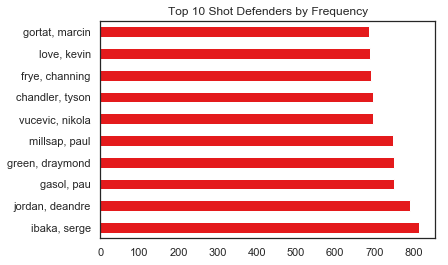

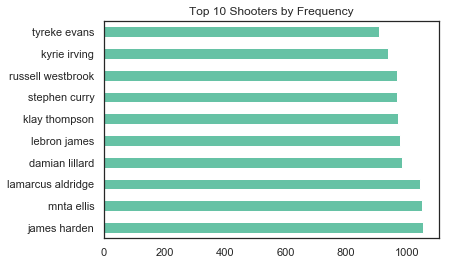

In [15]:
sns.set(style='white')
nba_df['closest_defender'].value_counts().head(10).plot.barh(
    title='Top 10 Shot Defenders by Frequency',
    cmap='Set1'
)
plt.show()
nba_df['player_name'].value_counts().head(10).plot.barh(
    title='Top 10 Shooters by Frequency',
    cmap='Set2'
)
plt.show()

### FG Percentage

In [16]:
nba_df['shot_result'].value_counts() / len(nba_df['shot_result'])

missed    0.547532
made      0.452468
Name: shot_result, dtype: float64

The total dataset has 45% of the shots made, which is pretty good. It's also helpful that the dataset of missed vs. made is fairly well balanced.

### Touch Time and Final Margin

/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


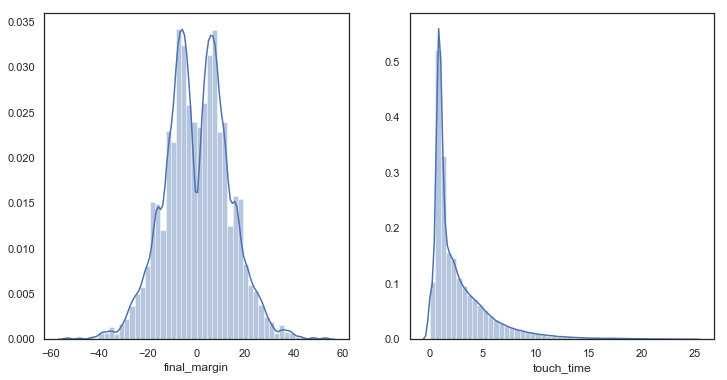

In [17]:
#For some reason there are negative touch times
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.distplot(
    nba_df['final_margin']
)

plt.subplot(1,2,2)
sns.distplot(
    nba_df['touch_time']
)
plt.show()

The distribution of point margins at the end of the game is very well centered around 0. There is a drop at 0, which makes sense, because tie games are rare to non-existent in the NBA. It also looks like most of the players in the dataset were quick to shoot the ball, with the vast majority taking a shot within 5 seconds of gaining posession.

### Shot Distance & Type

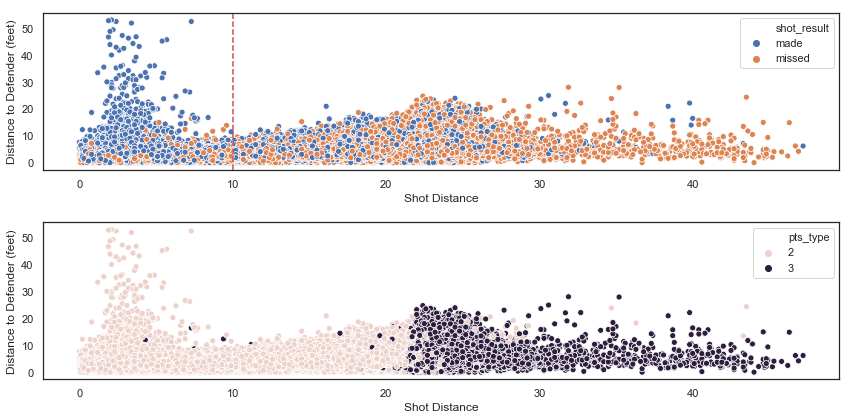

In [18]:
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
sns.scatterplot(
    x=nba_df['shot_dist'],
    y=nba_df['close_def_dist'],
    hue=nba_df['shot_result']
)
plt.ylabel('Distance to Defender (feet)')
plt.xlabel('Shot Distance')
plt.axvline(x=10, ls='--', c='r')

plt.subplot(2,1,2)
sns.scatterplot(
    x=nba_df['shot_dist'],
    y=nba_df['close_def_dist'],
    hue=nba_df['pts_type']
)
plt.ylabel('Distance to Defender (feet)')
plt.xlabel('Shot Distance')
plt.tight_layout()
plt.show()

Unsurprisingly the number of missed shots increase with distance and the number of made shots increase as distance decreases. The shorter side of the graphs indicate two different types of shots, fast-break layups and shots in the paint. The fast breaks are easily seen due to the sharp increase in the distance to the defender value.

Uh-oh, more cleaning. The NBA 3 point line ranges from 22'-23.9' depending on where you are on the court, but there are clear shots that are labeled with the wrong type of points. Let's correct that by putting a hard cutoff at 22'. That might still leave some shots incorrectly labelled, but the number will be far fewer than without cleaning.

In [19]:
#changing short shots to 2 pointers
mask = (
    (nba_df['shot_dist'] < 22) &
    (nba_df['pts_type'] == 3) 
)
nba_df.loc[mask, 'pts_type'] = 2 

#changing the made shots to 2 pointers
mask = (
    (nba_df['pts_type'] == 2) &
    (nba_df['pts'] == 3)
)
nba_df.loc[mask, 'pts'] = 2

#changing long shots to 3 pointers
mask = (
    (nba_df['shot_dist'] > 22) &
    (nba_df['pts_type'] == 2) 
)
nba_df.loc[mask, 'pts_type'] = 3
#changing the made long shots to 3 pointers
mask = (
    (nba_df['pts_type'] == 3) &
    (nba_df['pts'] == 2)
)
nba_df.loc[mask, 'pts'] = 3

#confirming the anomalies don't exist anymore
nba_df.loc[(nba_df['shot_dist'] < 22) & (nba_df['pts_type'] == 3), ['pts', 'pts_type', 'shot_dist']]  

,pts,pts_type,shot_dist


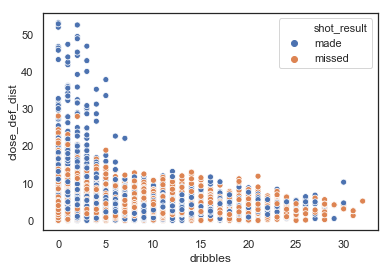

In [20]:
sns.scatterplot(
    x=nba_df['dribbles'],
    y=nba_df['close_def_dist'],
    hue=nba_df['shot_result']
)
plt.show()

There isn't a strong correlation to the number of dribbles and whether a shot is made, when comparing with the defender distance. Although, the fast break points that were mentioned earlier are still clearly grouped here with made shots. When a defender isn't within 30' of you, you better make the shot.

In [21]:
print('Average made field goals for shots < 10ft: {:.2f}'.format(nba_df.loc[nba_df['shot_dist'] < 10, 'fgm'].mean()))
print('Average made field goals for shots > 10ft: {:.2f}'.format(nba_df.loc[nba_df['shot_dist'] > 10, 'fgm'].mean()))

Average made field goals for shots < 10ft: 0.55
Average made field goals for shots > 10ft: 0.38


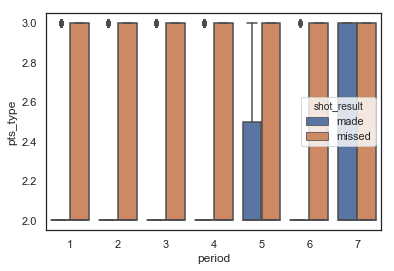

In [22]:
sns.boxplot(
    x = nba_df['period'],
    y = nba_df['pts_type'],
    hue=nba_df['shot_result']
)
plt.show()

In [25]:
nba_df.columns

Index(['game_id', 'matchup', 'location', 'w', 'final_margin', 'shot_number',
       'period', 'game_clock', 'shot_clock', 'dribbles', 'touch_time',
       'shot_dist', 'pts_type', 'shot_result', 'closest_defender',
       'closest_defender_player_id', 'close_def_dist', 'fgm', 'pts',
       'player_name', 'player_id', 'teams', 'match_date', 'team_one',
       'team_two', 'home_team', 'away_team'],
      dtype='object')

## Feature Engineering

In [23]:
nba_df.loc[:, 'all_alone'] = 0
nba_df.loc[nba_df['close_def_dist'] > 30, 'all_alone'] = 1

nba_df.loc[:, 'too_easy'] = 0
nba_df.loc[nba_df['shot_dist'] < 10, 'too_easy'] = 1

nba_df.loc[:, 'win'] = 0
nba_df.loc[nba_df['w'] == 'W', 'win'] = 1

nba_df.loc[:, 'home_game'] = 0
nba_df.loc[nba_df['location'] == 'H', 'home_game'] = 1

home_team_labels, home_team_uniques = pd.factorize(nba_df['home_team'])
nba_df['home_team_id'] = home_team_labels 

away_team_labels, away_team_uniques = pd.factorize(nba_df['away_team'])
nba_df['away_team_id'] = away_team_labels 

## Train/Test Split

In [24]:
nba_df.dropna(inplace=True)
features = [
    'game_id',
    'home_game',
    'win',
    'final_margin',
    'shot_number',
    'period',
    'shot_clock',
    'dribbles',
    'touch_time',
    'shot_dist',
    'pts_type',
    'closest_defender_player_id',
    'close_def_dist',
    'player_id',
    'home_team_id',
    'away_team_id',
    #'match_date',
    'all_alone',
    'too_easy'
]

X = nba_df.loc[:, features]
Y = nba_df.loc[:, 'fgm']

In [32]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=9725)

print('Number of rows in trainging: {}'.format(len(X_train)))
print('Number of rows in test: {}'.format(len(X_test)))

s = StandardScaler()
X_train = s.fit_transform(X_train)
X_test = s.transform(X_test)

Number of rows in trainging: 100600
Number of rows in test: 25151


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


## Random Forest Classifier

### Bayes Opt

In [29]:
params = {
    'n_estimators':Integer(50, 150),
    'max_depth':Integer(2, 10),
    'criterion':Categorical(['gini', 'entropy'])
}

rfc = RandomForestClassifier()

opt = BayesSearchCV(
    rfc,
    params,
    cv=5,
    n_iter=10,
    scoring='precision',
    verbose=1
)

opt.fit(X_train, Y_train)
print(opt.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   37.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   54.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   42.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   28.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   22.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   20.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   12.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   26.0s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   36.8s finished


{'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 89}


### Random Forest with Tuned Hyperparameters

In [31]:
rfc = RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=89)

rfc.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=89, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [32]:
Y_train_pred = rfc.predict(X_train)

print(confusion_matrix(Y_train, Y_train_pred))
print(classification_report(Y_train, Y_train_pred))

[[44689  6981]
 [26456 16187]]
              precision    recall  f1-score   support

           0       0.63      0.86      0.73     51670
           1       0.70      0.38      0.49     42643

   micro avg       0.65      0.65      0.65     94313
   macro avg       0.66      0.62      0.61     94313
weighted avg       0.66      0.65      0.62     94313



 Overall the model performance was pretty low. Likely there needs to be some more descriptive information about the shooter. Reaching out and getting their personal stats would be good. Previous season averages and player stats (height, wingspan, position), would be helpful to determine if the shot will go in or not. Or maybe a score of the gyms loudness (?). Lets try tuning an MLPClassifier model to see if the neural net can do better.

## Multi-Layer Perceptron Model

### Bayes Opt

In [26]:
params = {
    'alpha':Real(0.0001, 0.1, 'uniform')
}

mlp = MLPClassifier(
    hidden_layer_sizes=(500, 500, 250, 100,), 
    activation='relu', 
    solver='adam',
    n_iter_no_change=5,
    tol=0.001,
    learning_rate_init=0.01
)

opt = BayesSearchCV(
    mlp,
    params,
    cv=5,
    n_iter=5,
    random_state=34,
    scoring='precision',
    verbose=3
)

opt.fit(X_train, Y_train)
print(opt.best_params_)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] alpha=0.022261990539152995 ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=0.022261990539152995, score=0.6629458869206504, total= 1.6min
[CV] alpha=0.022261990539152995 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV]  alpha=0.022261990539152995, score=0.6678867740361152, total= 1.3min
[CV] alpha=0.022261990539152995 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.9min remaining:    0.0s


[CV]  alpha=0.022261990539152995, score=0.663046357615894, total= 1.4min
[CV] alpha=0.022261990539152995 ......................................
[CV]  alpha=0.022261990539152995, score=0.6365524402907581, total= 1.3min
[CV] alpha=0.022261990539152995 ......................................
[CV]  alpha=0.022261990539152995, score=0.6671080508474576, total= 1.4min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] alpha=0.09095294696164263 .......................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  7.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=0.09095294696164263, score=0.6798962386511025, total= 1.1min
[CV] alpha=0.09095294696164263 .......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV]  alpha=0.09095294696164263, score=0.6393643031784841, total= 1.0min
[CV] alpha=0.09095294696164263 .......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


[CV]  alpha=0.09095294696164263, score=0.6184514637904468, total=  53.0s
[CV] alpha=0.09095294696164263 .......................................
[CV]  alpha=0.09095294696164263, score=0.6549506087755571, total=  55.1s
[CV] alpha=0.09095294696164263 .......................................
[CV]  alpha=0.09095294696164263, score=0.6843833980292625, total= 1.1min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] alpha=0.014169735956101784 ......................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.0min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=0.014169735956101784, score=0.6337757261011733, total=  59.7s
[CV] alpha=0.014169735956101784 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   59.7s remaining:    0.0s


[CV]  alpha=0.014169735956101784, score=0.6512919068972881, total= 1.2min
[CV] alpha=0.014169735956101784 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.2min remaining:    0.0s


[CV]  alpha=0.014169735956101784, score=0.6431686046511628, total= 1.6min
[CV] alpha=0.014169735956101784 ......................................
[CV]  alpha=0.014169735956101784, score=0.6682405566600398, total= 2.0min
[CV] alpha=0.014169735956101784 ......................................
[CV]  alpha=0.014169735956101784, score=0.669202518363064, total=  56.8s
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] alpha=0.003457026533339835 ......................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  6.7min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=0.003457026533339835, score=0.6271659032065325, total= 1.2min
[CV] alpha=0.003457026533339835 ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.2min remaining:    0.0s


[CV]  alpha=0.003457026533339835, score=0.6784660766961652, total= 1.2min
[CV] alpha=0.003457026533339835 ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.4min remaining:    0.0s


[CV]  alpha=0.003457026533339835, score=0.6584066080468958, total=  55.4s
[CV] alpha=0.003457026533339835 ......................................
[CV]  alpha=0.003457026533339835, score=0.6451882845188285, total= 1.2min
[CV] alpha=0.003457026533339835 ......................................
[CV]  alpha=0.003457026533339835, score=0.6479840496233938, total= 1.2min
Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] alpha=0.06324525619249455 .......................................


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  5.8min finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  alpha=0.06324525619249455, score=0.6123423116263211, total=  55.6s
[CV] alpha=0.06324525619249455 .......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   55.6s remaining:    0.0s


[CV]  alpha=0.06324525619249455, score=0.6558321807284463, total=  59.6s
[CV] alpha=0.06324525619249455 .......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.9min remaining:    0.0s


[CV]  alpha=0.06324525619249455, score=0.6198430267659489, total=  54.2s
[CV] alpha=0.06324525619249455 .......................................
[CV]  alpha=0.06324525619249455, score=0.6377295492487479, total=  49.2s
[CV] alpha=0.06324525619249455 .......................................
[CV]  alpha=0.06324525619249455, score=0.6269005847953216, total=  53.8s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  4.5min finished


{'alpha': 0.022261990539152995}


### MLP with Tuned Hyperparameters

In [38]:
mlp = MLPClassifier(
    hidden_layer_sizes=(20000,), 
    activation='relu', 
    solver='adam',
    n_iter_no_change=5,
    tol=0.001,
    learning_rate_init=0.01,
    alpha=0.0222,
    verbose=1
)

mlp.fit(X_train, Y_train)

Iteration 1, loss = 0.68392953
Iteration 2, loss = 0.65723262
Iteration 3, loss = 0.65399074
Iteration 4, loss = 0.65274915
Iteration 5, loss = 0.65233537
Iteration 6, loss = 0.65220182
Iteration 7, loss = 0.65205367
Iteration 8, loss = 0.65193518
Iteration 9, loss = 0.65172138
Iteration 10, loss = 0.65155989
Training loss did not improve more than tol=0.001000 for 5 consecutive epochs. Stopping.


MLPClassifier(activation='relu', alpha=0.0222, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(20000,), learning_rate='constant',
       learning_rate_init=0.01, max_iter=200, momentum=0.9,
       n_iter_no_change=5, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.001,
       validation_fraction=0.1, verbose=1, warm_start=False)

In [39]:
Y_train_pred = mlp.predict(X_train)
Y_test_pred = mlp.predict(X_test)

print('__________     Training Summary     __________')
print('Confusion Matrix:\n{}\n'.format(confusion_matrix(Y_train, Y_train_pred)))
print(classification_report(Y_train, Y_train_pred))

print('__________     Test Summary     __________')
print('Confusion Matrix:\n{}\n'.format(confusion_matrix(Y_test, Y_test_pred)))
print(classification_report(Y_test, Y_test_pred))

__________     Training Summary     __________
Confusion Matrix:
[[45859  9218]
 [29048 16475]]

              precision    recall  f1-score   support

           0       0.61      0.83      0.71     55077
           1       0.64      0.36      0.46     45523

   micro avg       0.62      0.62      0.62    100600
   macro avg       0.63      0.60      0.58    100600
weighted avg       0.63      0.62      0.60    100600

__________     Test Summary     __________
Confusion Matrix:
[[11447  2309]
 [ 7269  4126]]

              precision    recall  f1-score   support

           0       0.61      0.83      0.71     13756
           1       0.64      0.36      0.46     11395

   micro avg       0.62      0.62      0.62     25151
   macro avg       0.63      0.60      0.58     25151
weighted avg       0.63      0.62      0.60     25151



## Conclusion

The neural net performed about the same as the Random Forest. Both did a pretty poor job. Likely this dataset needs a much larger feature set to properly see the effects of the neural nets increased performance. This could also be a good dataset to use a recursive neural net so that it can learn what is making the shot go in.

As far as complexity and resources go, the neural net is far hungrier than the random forest. Tuning hyperparameters and training the models took far longer than the Random Forest. Given the results, it was likely not necessary for performance in this application.